In [15]:
import os
import glob
import datetime
import tarfile
import urllib.request

from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.metrics import classification_report, confusion_matrix

import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [16]:
url  = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/"
fname = "17flowers.tgz"
train_dir      = "dataset"

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

In [17]:
# download and extract dataset
if not os.path.exists(fname):
    response = urllib.request.urlretrieve(url+fname, fname)
    tf = tarfile.open(fname)
    tf.extractall(train_dir)
    print("[Info] Data has been downloaded and extracted")

In [18]:
#-----------------------------------
#    FEATURE DESCRIPTORS
#-----------------------------------

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [19]:
# get paths of all images and sort them
image_paths = glob.glob(train_dir + "/jpg/*.jpg")
image_paths.sort()
#print(image_paths)
  
# empty lists to hold feature vectors and labels
global_features = []
labels          = []

#--------------------
# tunable-parameters
#--------------------
images_per_class = 80
fixed_size       = tuple((500, 500))
train_path       = "dataset/train"
h5_data          = "output/data.h5"
h5_labels        = "output/labels.h5"
bins             = 8

current_label = 0

print("Total images: ", len(image_paths))
for index, file in enumerate(image_paths, start=1):
    
    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # update the list of labels and feature vectors
    labels.append(current_label)
    global_features.append(global_feature)
    #print(x,format(np.array(global_features).shape))
      
    # update image class label
    if index%images_per_class == 0:
        print("[STATUS] class", current_label, " images processed...")
        current_label += 1

print("[STATUS] completed Global Feature Extraction...")

Total images:  1360
[STATUS] class 0  images processed...
[STATUS] class 1  images processed...
[STATUS] class 2  images processed...
[STATUS] class 3  images processed...
[STATUS] class 4  images processed...
[STATUS] class 5  images processed...
[STATUS] class 6  images processed...
[STATUS] class 7  images processed...
[STATUS] class 8  images processed...
[STATUS] class 9  images processed...
[STATUS] class 10  images processed...
[STATUS] class 11  images processed...
[STATUS] class 12  images processed...
[STATUS] class 13  images processed...
[STATUS] class 14  images processed...
[STATUS] class 15  images processed...
[STATUS] class 16  images processed...
[STATUS] completed Global Feature Extraction...


In [20]:
# Label classes
train_labels = ['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']
# sort the training labels
train_labels.sort()
print(train_labels)

['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


In [21]:
# get the overall feature vector size
print("[STATUS] feature vector size:",len(global_features))

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels size: ",len(labels))

if not os.path.exists('output'):
    os.makedirs('output')

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(labels))

h5f_data.close()
h5f_label.close()


[STATUS] feature vector size: 1360
[STATUS] feature vector normalized...
[STATUS] target labels size:  1360


In [22]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")


[STATUS] features shape: (1360, 532)
[STATUS] labels shape: (1360,)
[STATUS] training started...


In [23]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))


[STATUS] splitted train and test data...
Train data  : (1224, 532)
Test data   : (136, 532)
Train labels: (1224,)
Test labels : (136,)


In [24]:
# Try DT classifier with entropy


# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", splitter="random", max_depth=2)

# Train Decision Tree Classifer
clf = clf.fit(trainDataGlobal,trainLabelsGlobal)

#Predict the response for test dataset
y_pred = clf.predict(testDataGlobal)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(testLabelsGlobal, y_pred)*100)

Accuracy: 13.23529411764706


In [25]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(splitter="random")

# Train Decision Tree Classifer
clf = clf.fit(trainDataGlobal,trainLabelsGlobal)

#Predict the response for test dataset
y_pred = clf.predict(testDataGlobal)

print(testDataGlobal.shape)
print(y_pred.shape)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(testLabelsGlobal, y_pred)*100)

(136, 532)
(136,)
Accuracy: 42.64705882352941


In [27]:
#Visualizing Decision Trees
print(global_features[1].shape)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                #special_characters=True,feature_names = feature_cols,class_names=['0','1'])
                special_characters=True,feature_names = global_features[1])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bnDT.png')
Image(graph.create_png())

(532,)


InvocationException: GraphViz's executables not found

In [28]:
print(classification_report(testLabelsGlobal, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.22      0.22         9
           1       0.57      0.50      0.53         8
           2       0.44      0.50      0.47         8
           3       0.60      0.38      0.46         8
           4       0.45      0.50      0.48        10
           5       0.67      0.50      0.57         8
           6       0.33      0.20      0.25         5
           7       0.17      0.11      0.13         9
           8       0.62      0.71      0.67         7
           9       0.46      0.46      0.46        13
          10       0.62      0.83      0.71         6
          11       0.00      0.00      0.00         4
          12       0.36      0.56      0.43         9
          13       0.50      0.50      0.50         8
          14       0.17      0.17      0.17         6
          15       0.40      0.40      0.40        10
          16       0.44      0.50      0.47         8

    accuracy              

<Figure size 432x288 with 0 Axes>

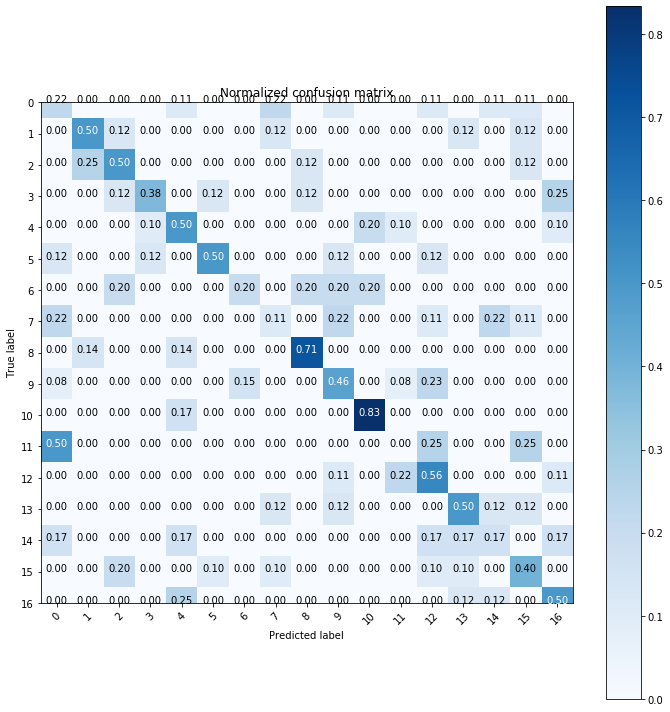

In [29]:
# show the confusion matrix of our predictions


class_names = np.unique(labels)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(testLabelsGlobal, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()


LR: 0.500127 (0.048811)
LDA: 0.440357 (0.052933)
KNN: 0.375843 (0.056226)
CART: 0.444469 (0.042406)
RF: 0.657697 (0.036354)
NB: 0.373351 (0.036408)
SVM: 0.052346 (0.036915)


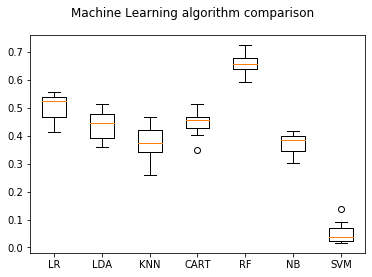

In [30]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

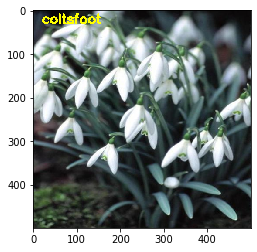

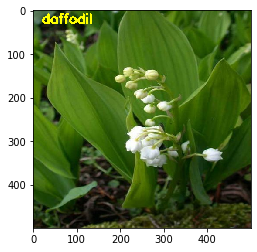

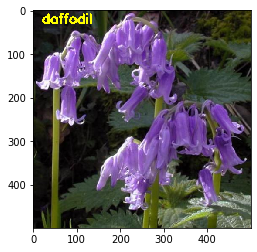

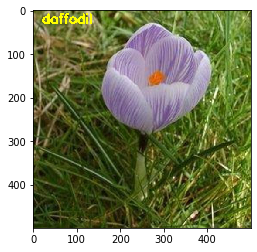

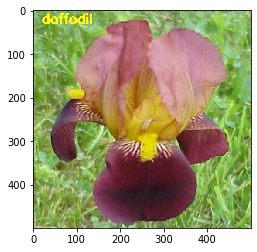

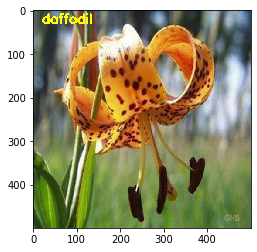

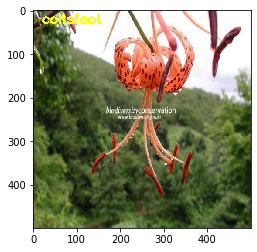

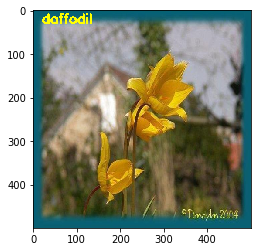

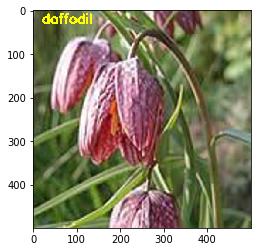

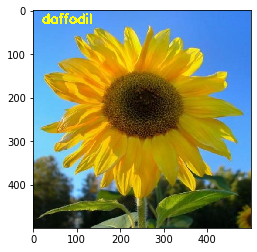

In [32]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_f = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    
    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_f.reshape(-1,1))

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()